# <span style="color:#F72585">DataSets y DataLoaders</span>


## <span style="color:#4361EE">Introducción</span>

El código para procesar muestras de datos puede resultar complicado y difícil de mantener; idealmente queremos que nuestro código de datasets se desacople de nuestro código de entrenamiento modelo para una mejor legibilidad y modularidad. PyTorch proporciona dos primitivas de datos: `torch.utils.data.DataLoader` y `torch.utils.data.Dataset` que le permiten utilizar conjuntos de datos precargados, así como sus propios datos. 

`Dataset` almacena las muestras y sus etiquetas correspondientes, y `DataLoader` envuelve un iterable alrededor del conjunto de datos para permitir un fácil acceso a las muestras.

## <span style="color:#4361EE">Carga de un Dataset</span>

In [8]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [9]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## <span style="color:#4361EE">Iterando y visualizando el dataset</span>

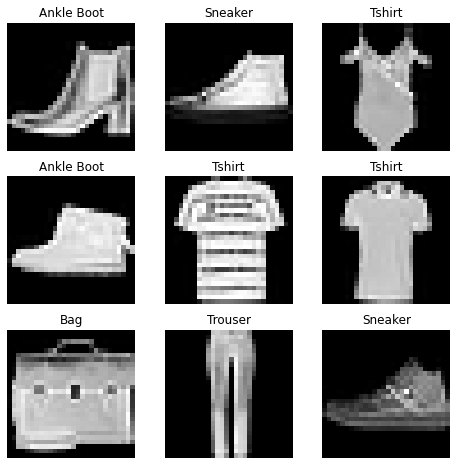

In [10]:
label_map = {
    0: 'Tshirt',
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",   
}
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size =(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [11]:
img.shape

torch.Size([1, 28, 28])

## <span style="color:#4361EE">Creación de un conjunto de datos personalizado para sus archivos</span>

En este ejemplo, las imágenes FashionMNIST se almacenan en un directorio img_dir, y sus etiquetas se almacenan por separado en un archivo CSV  `annotations_file`.


In [12]:
import os
import pandas as pd
from torchvision.io import read_image

In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __get_item__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label =  self.image_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
        

Las etiquetas (labels) del archivo en el ejemplo *labels.csv*  lucen como

### Leemos los datos desde una archivo comprimido

Los datos fueron bajados desde la fuente usando wget. Por favor revise los detalles. Para Windows revise [aquí](http://gnuwin32.sourceforge.net/packages/wget.htm)

In [ ]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

### Imágenes de entrenamiento

In [3]:
import gzip
f = gzip.open('./data/FashionMNIST/raw/train-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 60000

import numpy as np
f.read(16) # omite los primeros 16 bytes
buf = f.read(image_size * image_size * num_images)
data_train = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data_train = data_train.reshape(num_images, image_size, image_size, 1)
print(data_train.shape)

(60000, 28, 28, 1)


### Etiquetas de entrenamiento

In [15]:
import gzip
f = gzip.open('./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz','r')

num_labels = 60000

import numpy as np
f.read(8) # omite los primeros 8 bytes
buf = f.read(num_labels)
label_train = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
print(label_train.shape)
print(label_train[:20])

(60000,)
[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4]


### Imágenes de test

In [16]:
import gzip
f = gzip.open('./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 10000

import numpy as np
f.read(16) # omite los primeros 16 bytes
buf = f.read(image_size * image_size * num_images)
data_test = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data_test = data_test.reshape(num_images, image_size, image_size, 1)
print(data_test.shape)

(10000, 28, 28, 1)


### Etiquetas de test

In [17]:
import gzip
f = gzip.open('./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz','r')

num_labels = 10000

import numpy as np
f.read(8) # omite los primeros 8 bytes
buf = f.read(num_labels)
label_test = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
print(label_test.shape)
print(label_test[:20])

(10000,)
[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0]


### Crea datasets para estos datos

In [18]:
class ImageDataset(Dataset):
    def __init__(self, labels, images, transform=None, target_transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label =  self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
        

In [19]:
train_dataset = ImageDataset(label_train, data_train)
test_dataset = ImageDataset(label_test, data_test)

## <span style="color:blue">Preparando sus datos para entrenamiento con DataLoaders</span>

In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [21]:
test_dataloader

### Iterando a lo largo del DataLoader

Cada iteración retorna un batch (`batch_size=64`) de datos (`train_features` y `train_labels`). Dado que *shuffel=True* en el ejemplo, todos los lotes de datos se mezclan. Un control mpas fino para establecer el orden se obtiene usando `Samplers`.

Feature batch shape: torch.Size([64, 28, 28, 1])
Labels batch shape: torch.Size([64])


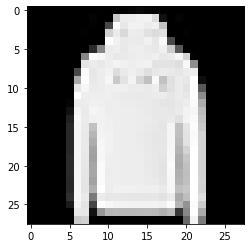

Label: 2


In [22]:
# Despliega imagen y etiqueta
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].squeeze()# primer elemento del batch 
# squeeze elimina ejes de tamaño 1.
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {label}')

## <span style="color:blue">Referencias</span> 


1. Basado en los [tutoriales de Pytorch](https://pytorch.org/tutorials/)
1. [Deep learning for coders with FastAI and Pytorch](http://library.lol/main/F13E85845AE48D9FD7488FE7630A9FD3)